In [24]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

import AttributionMethods as attr
import guidedIGBuilder as GIG_Builder
import AGI as AGI


model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to("cuda:0")

# standard image resize dimension for ResNet
img_hw = 224

# transforms for IG, LIG, and IDG
transform = transforms.Compose([
     transforms.Resize((img_hw, img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

# standard ImageNet normalization for IG, LIG, and IDG
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

# transforms and normalization for GIG and AGI
resize = transforms.Resize((img_hw, img_hw))
crop = transforms.CenterCrop(img_hw)
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# color map for Captum attribution visualization
default_cmap = LinearSegmentedColormap.from_list('custom blue',  [(0, '#ffffff'), (0.25, '#0000ff'), (1, '#0000ff')], N = 256)   

<h1>Utility methods for the attributions</h1>

In [25]:
# returns the class index and name of an image 
def getClass(input, model, device):
    input = transform_normalize(input)
    input = torch.unsqueeze(input, 0)

    # calculate a prediction
    input = input.to(device)
    output = model(input)

    _, index = torch.max(output, 1)

    # open the class list so the detected class string can be returned for printing
    with open('class_maps/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    return index[0], classes[index[0]]


# Boilerplate GIG methods from https://github.com/PAIR-code/saliency.
def LoadImage(file_path, resize, crop):
    im = Image.open(file_path)
    im = resize(im)
    im = crop(im)
    im = np.asarray(im)
    return im

def PreprocessImages(images):
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = normalize.forward(images)
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, model, device, call_model_args = None, expected_keys = None):
    images = PreprocessImages(images)
    target_class_idx = call_model_args[class_idx_str]
    output = model(images.to(device))
    
    # capture the logit before the output is crushed by softmax
    logit = ((output[0])[target_class_idx]).detach().cpu().numpy().item()

    m = torch.nn.Softmax(dim=1)
    output = m(output)

    if GIG_Builder.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))[0]
        grads = torch.movedim(grads, 1, 3)
        gradients = grads.detach().numpy()
        
        return {GIG_Builder.INPUT_OUTPUT_GRADIENTS: gradients}, logit


<h1>Load an image and get the class</h1>

cougar 286


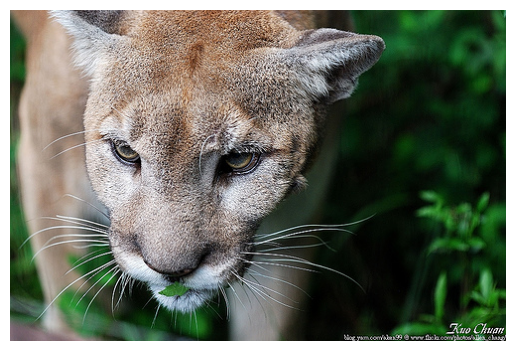

In [46]:
image_path = "img/cougar.JPEG"
img = Image.open(image_path)

trans_img = transform(img)

device = "cuda:0"

class_index, class_name = getClass(trans_img, model, device)

print(class_name, class_index.item())
plt.axis("off")
plt.imshow(img)
plt.show()

<h1>Generate attributions</h1>

In [47]:
steps = 50
batch_size = 25
baseline = 0

In [48]:
# alpha star = 1, plain IG attribution
ig, _, _ = attr.IGParallel(trans_img, model, steps, batch_size, 1, baseline, device, class_index)

In [49]:
# alpha star = 0.9, Left IG attribution
lig, _, _ = attr.IGParallel(trans_img, model, steps, batch_size, .9, baseline, device, class_index)

In [50]:
# get integrated decision gradients attribution
idg, _, _, _ = attr.IDG(trans_img, model, steps, batch_size, baseline, device, class_index)

In [51]:
# Guided IG from from https://github.com/PAIR-code/saliency
gig_img = LoadImage(image_path, resize, crop)
gig_img = gig_img.astype(np.float32)
call_model_args = {class_idx_str: class_index.item()}
guided_ig = GIG_Builder.GuidedIG()
baseline = np.zeros(gig_img.shape)

# GIG attribution
gig = guided_ig.GetMask(gig_img, model, device, call_model_function, call_model_args, x_baseline=baseline, x_steps=steps, max_dist=1.0, fraction=0.5)

In [52]:
# AGI from https://github.com/pd90506/AGI/blob/master/AGI_main.py
epsilon = 0.05
topk = 1
max_iter = 20
agi_img = AGI.LoadImage(image_path, resize, crop)
agi_img = agi_img.astype(np.float32) 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = AGI.Normalize(mean, std)
modified_model = nn.Sequential(norm_layer, model).to(device)        
selected_ids = range(0, 999, int(1000 / topk))

_, _, agi = AGI.test(modified_model, device, agi_img, epsilon, topk, selected_ids, max_iter)

# perform AGI thresholding 
percentile = 80
upperbound = 99
hm = agi
hm = np.mean(hm, axis=0)
q = np.percentile(hm, percentile)
u = np.percentile(hm, upperbound)
hm[hm<q] = q
hm[hm>u] = u
hm = (hm-q)/(u-q)

# AGI attribution
agi = np.reshape(hm, (img_hw, img_hw, 1))

<h1>Visualize the attributions </h1>

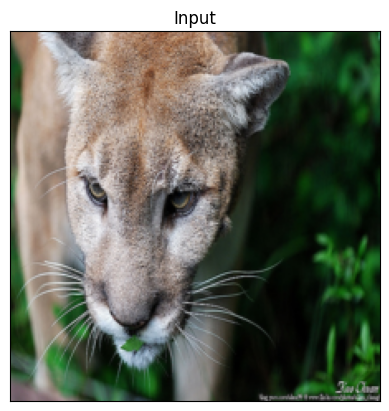

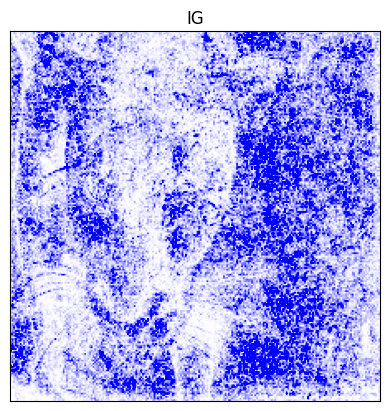

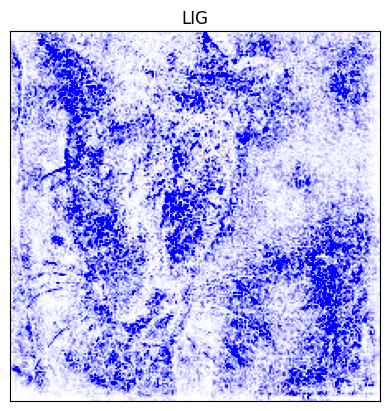

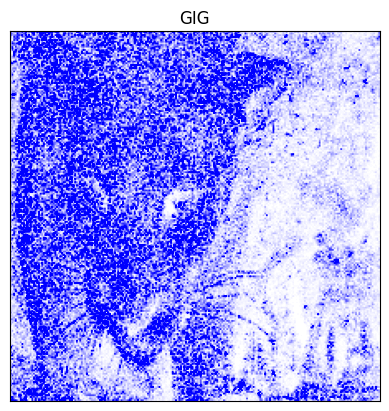

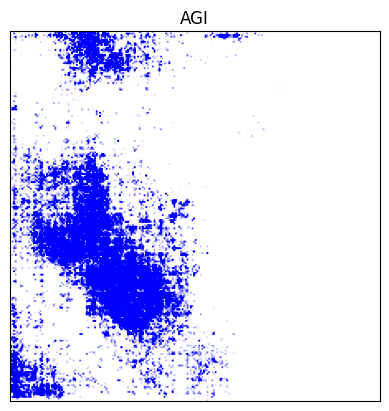

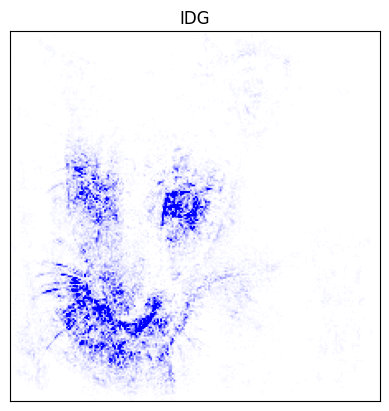

In [53]:
# transform the [C, H, W] image and attributions to [H, W, C] for display
img_print = np.transpose(trans_img.squeeze().detach().cpu().numpy(), (1, 2, 0))
ig_print = np.transpose(ig.squeeze().detach().cpu().numpy(), (1,2,0))
lig_print = np.transpose(lig.squeeze().detach().cpu().numpy(), (1,2,0))
idg_print = np.transpose(idg.squeeze().detach().cpu().numpy(), (1,2,0))

gig_print = gig
agi_print = agi

fig, _ = viz.visualize_image_attr(None, img_print, 
                    method="original_image",
                    title="Input",
                    plt_fig_axis = plt.subplots(1, 1))

fig, _ = viz.visualize_image_attr(ig_print,
                            img_print,
                            method='heat_map',
                            title="IG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))

fig, _ = viz.visualize_image_attr(lig_print,
                            img_print,
                            method='heat_map',
                            title="LIG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))


fig, _ = viz.visualize_image_attr(gig_print,
                            img_print,
                            method='heat_map',
                            title="GIG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))


fig, _ = viz.visualize_image_attr(agi_print,
                            img_print,
                            method='heat_map',
                            title="AGI",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))


fig, _ = viz.visualize_image_attr(idg_print,
                            img_print,
                            method='heat_map',
                            title="IDG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))